In [1]:
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader
from tqdm import tqdm

from train2 import FCModel, CNNModel, ResCNN1DLayer, FPathDataset
from src.dataloaders import FPathLazyDataset

### Model Load

In [2]:
# CNNModel
model = torch.load("/home/work/joono/VTFSketch/weights/best_CNNModel_acc78.31.pth")

# FCModel
# model = torch.load("/home/work/joono/VTFSketch/weights/best_FCModel_acc77.46.pth")

model = model.to('cuda')
model = model.train()

### Calculate test accuracy

In [90]:
test_dset = FPathDataset("/home/work/joono/VTFSketch/dataset/test.npz")
test_dloader = DataLoader(test_dset, batch_size=40960, num_workers=24)


sTP, sFP, sTN, sFN = 0, 0, 0, 0
with torch.no_grad():
    for fpath, target in tqdm(test_dloader):
        fpath, target = fpath.to('cuda'), target.to('cuda')
        y_hat = model(fpath)

        torch.sum((y_hat.squeeze() > 0.5) == target)

        sTP += torch.sum(((y_hat.squeeze() > 0.5) == target) * (target == 1))
        sFP += torch.sum(((y_hat.squeeze() > 0.5) == target) * (target == 0))
        sTN += torch.sum(((y_hat.squeeze() < 0.5) == target) * (target == 0))
        sFN += torch.sum(((y_hat.squeeze() < 0.5) == target) * (target == 1))

accuracy = (sTP + sTN) / (sTP + sFP + sTN + sFN)

print(f"Acc: {100 * accuracy:2.2f}")
print(f"\tTP: {sTP}, FN: {sFN}")
print(f"\tFP: {sFP}, TN: {sTN}")

100%|██████████| 142/142 [00:04<00:00, 29.52it/s]

Acc: 76.82
	TP: 3542394, FN: 506580
	FP: 836741, TN: 909902


# Test using dataset

In [92]:
dset = FPathLazyDataset(config_path="/home/work/joono/VTFSketch/dataset/test.yaml")

In [102]:
fpath, _, infodraw, target = dset[2]

print(f"fpath: {type(fpath), fpath.shape}, infodraw: {type(infodraw), infodraw.shape}, target: {type(target), target.shape}")

fpath_tensor = torch.tensor(fpath).unsqueeze(0)
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)
target_tensor = torch.tensor(target).unsqueeze(0)

fpath_tensor = fpath_tensor.to('cuda')
infodraw_tensor = infodraw_tensor.to('cuda')
target_tensor = target_tensor.to('cuda')

print(f"fpath_tensor: {type(fpath_tensor), fpath_tensor.shape}, infodraw: {type(infodraw_tensor), infodraw_tensor.shape}, target_tensor: {type(target_tensor), target_tensor.shape}")

fpath: (<class 'numpy.ndarray'>, (21, 1024, 1024)), infodraw: (<class 'torch.Tensor'>, torch.Size([1, 1024, 1024])), target: (<class 'torch.Tensor'>, torch.Size([1, 1024, 1024]))
fpath_tensor: (<class 'torch.Tensor'>, torch.Size([1, 21, 1024, 1024])), infodraw: (<class 'torch.Tensor'>, torch.Size([1, 1, 1024, 1024])), target_tensor: (<class 'torch.Tensor'>, torch.Size([1, 1, 1024, 1024]))


/tmp/ipykernel_2534349/3010904649.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)
/tmp/ipykernel_2534349/3010904649.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target).unsqueeze(0)


# Test using wild image

In [3]:
from src.preprocesses import VTFPreprocessor, ImagePreprocessor, InfodrawPreprocessor

In [4]:
vtf_path = "/home/work/joono/VTFSketch/dataset/hard_data/vtfs/simple_curve_fpath_of_infodraw.npz"
infodraw_path = "/home/work/joono/VTFSketch/dataset/hard_data/infodraws/simple_curve_out.png"

fpath      = VTFPreprocessor.get(vtf_path)
infodraw  = InfodrawPreprocessor.get(infodraw_path)

fpath_tensor = torch.tensor(fpath).unsqueeze(0).to('cuda')
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to('cuda')

/tmp/ipykernel_2011/1736704625.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to('cuda')


# Inference

In [5]:
model = model.to('cuda')

_, _, H, W = infodraw_tensor.shape

result = infodraw_tensor.clone()

target_indices = torch.where(infodraw_tensor < 0.99)
selected_fpath_tensor = fpath_tensor[target_indices[0], :, target_indices[2], target_indices[3]]
print(f"selected_fpath_tensor: {selected_fpath_tensor.shape}")

with torch.no_grad():
    y_hat = model(selected_fpath_tensor)

y_hat = y_hat.squeeze()

for i, (b, c, h, w) in enumerate(zip(target_indices[0], target_indices[1], target_indices[2], target_indices[3], )):
    result[b, c, h, w] = y_hat[i]

selected_fpath_tensor: torch.Size([6077, 21])


In [6]:
np_result = result.squeeze().detach().cpu().numpy()

True

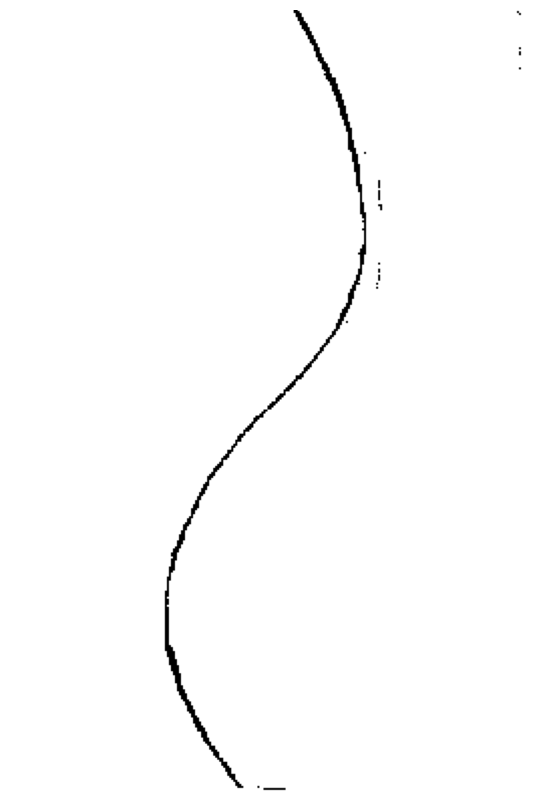

In [7]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(np_result > 0.5, cmap='gray')
plt.axis('off')
cv2.imwrite("test_FC_903.png", 255 * np.array(np_result > 0.5, dtype=np.float32))

(-0.5, 1023.5, 1023.5, -0.5)

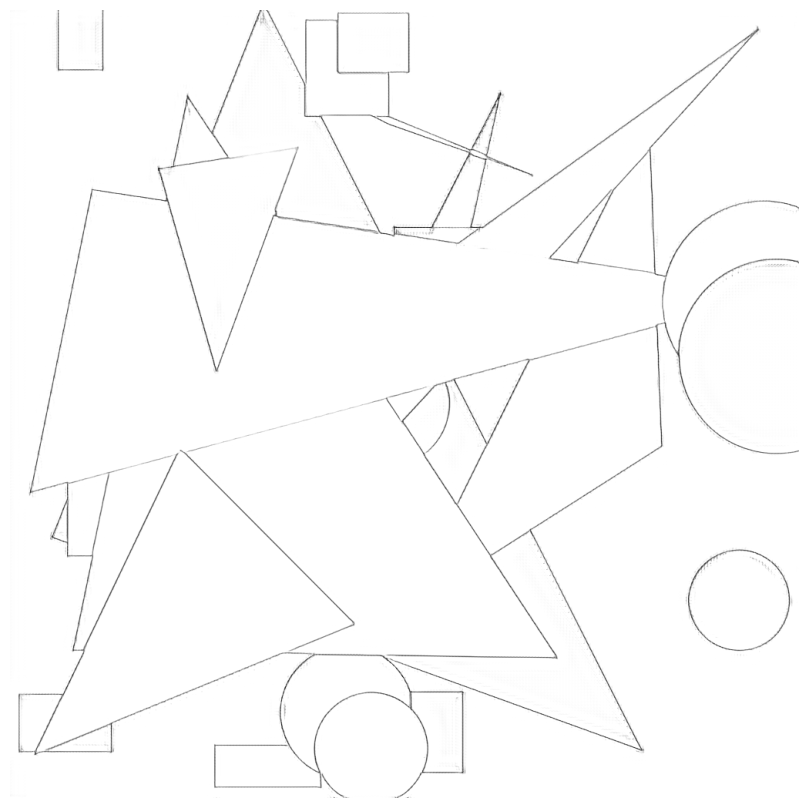

In [70]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(infodraw.squeeze(), cmap='gray')
plt.axis('off')

In [54]:
model = model.to('cuda')

_, _, H, W = infodraw_tensor.shape

result = infodraw_tensor.clone()
with torch.no_grad():
    for h in tqdm(range(H)):
        for w in range(W):
            if infodraw_tensor[0, 0, h, w] < 0.99:
                y_hat = model(fpath_tensor[0, :, h, w].unsqueeze(0))
                result[0, 0, h, w] = y_hat

100%|██████████| 1024/1024 [01:04<00:00, 15.78it/s]


In [55]:
np_result = result.squeeze().detach().cpu().numpy()

(-0.5, 1023.5, 1023.5, -0.5)

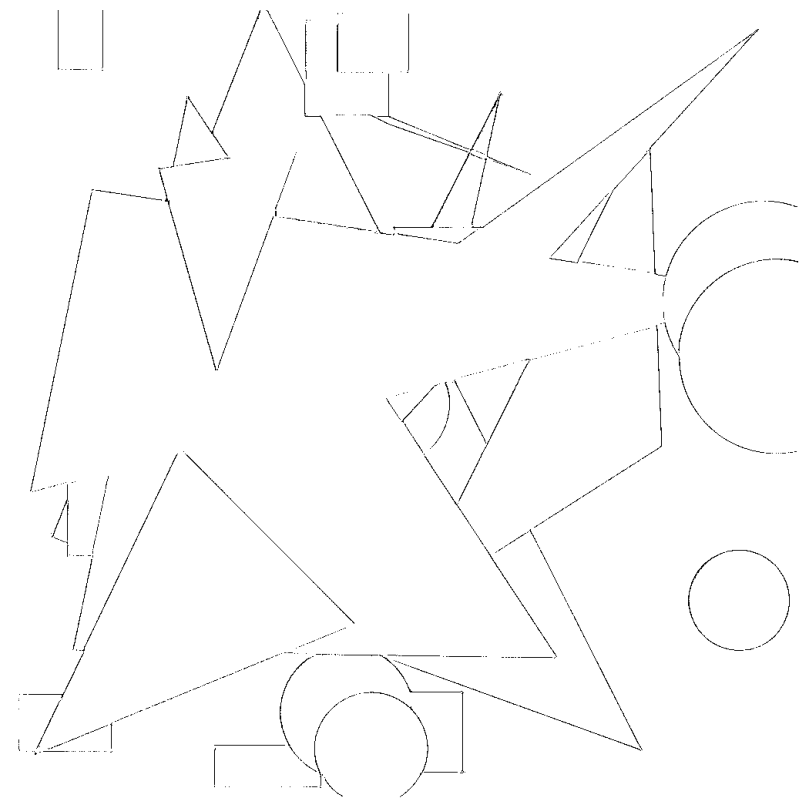

In [75]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(np_result > 0.5, cmap='gray')
plt.axis('off')